# Projet conductivité thermique d'une maison 
### CHPS0706
Eliot CALDERON-Y-MORA <br>
Clément JOUD'HEUIL

In [3]:
#Importations
import numpy as np
import math
import matplotlib.pyplot as plt

In [4]:
#Chargement du maillage
FichierMaillage = "maison.msh"

## Fonctions

In [5]:
# Lecture du ficher de maillage (msh)
def lit_fichier_msh(fichier_msh):
    with open(fichier_msh, 'r') as f:
        # Lecture de la première ligne
        nbn, nbe, nba = map(int, f.readline().split())
        
        # Lecture des coordonnées et références des noeuds
        coord = np.zeros((nbn, 2))
        refn = np.zeros(nbn, dtype=int)
        for i in range(nbn):
            line = f.readline().split()
            coord[i] = [float(line[0]), float(line[1])]
            refn[i] = int(line[2])
        
        # Lecture des triangles et leurs références
        trian = np.zeros((nbe, 3), dtype=int)
        reft = np.zeros(nbe, dtype=int)
        for i in range(nbe):
            line = f.readline().split()
            trian[i] = [int(line[0])-1, int(line[1])-1, int(line[2])-1]
            reft[i] = int(line[3])
        
        # Lecture des arêtes et leurs références
        ar = np.zeros((nba, 2), dtype=int)
        refa = np.zeros(nba, dtype=int)

        # Séléction des arêtes de bords de condition 1 soit Dirichlet
        GammaF = []
        GammaF2 = []
        for i in range(nba):
            line = f.readline().split()
            ar[i] = [int(line[0])-1, int(line[1])-1]
            refa[i] = int(line[2])
            if refa[i] == 1:  # Par exemple, sélectionner les arêtes de référence 1
                GammaF.append(i)
            if refa[i] == 3:  # Par exemple, sélectionner les arêtes de référence 3
                GammaF2.append(i)

    
    return nbn, nbe, nba, coord, trian, ar, refn, reft, refa, GammaF, GammaF2

In [6]:
# Calcul du pas et de la qualité du maillage
def pas_et_qualite_maillage(coord, trian):
    h_max = 0  # Pas du maillage
    Q_h_max = 0  # Qualité du maillage
    
    for triangle in trian:
        # Récupération des coordonnées des sommets du triangle
        S1, S2, S3 = coord[triangle[0]], coord[triangle[1]], coord[triangle[2]]
        
        # Calcul des longueurs des arêtes
        L1 = np.linalg.norm(S2 - S1)
        L2 = np.linalg.norm(S3 - S2)
        L3 = np.linalg.norm(S1 - S3)
        
        # Calcul du pas du triangle
        h_T = max(L1, L2, L3)
        
        # Mise à jour du pas du maillage
        h_max = max(h_max, h_T)
        
        # Calcul du demi-périmètre
        s = (L1 + L2 + L3) / 2
        
        # Calcul de l'aire du triangle (formule de Héron)
        aire = np.sqrt(s * (s - L1) * (s - L2) * (s - L3))
        
        # Calcul du rayon du cercle inscrit
        r_T = aire / s
        
        # Calcul de la qualité du triangle
        Q_T = (np.sqrt(3) / 6) * (h_T / r_T)
        
        # Mise à jour de la qualité du maillage
        Q_h_max = max(Q_h_max, Q_T)

    return h_max, Q_h_max

In [7]:
# Fonctions constantes
def fct_uE(uE): # temperature exterieur
    return uE


def fct_f(f): # source de chaleur
    return f



def fct_kappa(): # conductivité thermique du maillage
    return 3e-2



def fct_alpha(n): # coefficient de transfert thermique au bord
    alpha0=2e-1
    return n * alpha0

In [8]:
def coeffelem_P1_rigid(x1, x2, x3, y1, y2, y3, kappa):
    """
    Retourne la matrice qui établie la resistance d'un triangle (rigidité), ici on parle de la propagation de chaleur.
    Dans la diagonale, on retrouve le niveau d'influence de chaque sommet dans la rigidité du triangle.
    Dans le reste (hors diagonale) on retrouve la résistance entre 2 sommets (plus c'est élevé plus ils sont lié)
    """ 

    #calcul de l'air du triangle
    mesTl =  0.5 * abs(x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))

    # Calcul de l'influence des sommets sur la matrice
    k11 = (kappa/(4*mesTl)) * ((x2-x3)**2 + (y2-y3)**2)
    k22 = (kappa/(4*mesTl)) * ((x3-x1)**2 + (y3-y1)**2)
    k33 = (kappa/(4*mesTl)) * ((x1-x2)**2 + (y1-y2)**2)

    # Calcul du lien de rigidité entre chaque sommet
    k12 = k21 = (kappa/(4*mesTl)) * (-(x1-x3)*(x2-x3)-(y1-y3)*(y2-y3))
    k13 = k31 = (kappa/(4*mesTl)) * (-(x3-x2)*(x1-x2)-(y3-y2)*(y1-y2))
    k23 = k32 = (kappa/(4*mesTl)) * (-(x2-x1)*(x3-x1)-(y2-y1)*(y3-y1))


    kl = np.array([
        [k11, k12, k13],
        [k21, k22, k23],
        [k31, k32, k33]
    ])

    return kl

In [9]:
def coeffelem_P1_masse(x1, x2, x3, y1, y2, y3):

    mesTl =  0.5 * abs(x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))

    ml = (mesTl/3) * np.array([[1,0,0],[0,1,0],[0,0,1]])

    return ml

In [10]:
def coeffelem_P1_source(x1, x2, x3, y1, y2, y3, f):
    """
    On détermine ici le niveau d'influence de chaque sommet par rapport à la source de chaleur
    """

    # Calculer la mesure (aire) de l'élément triangle
    mesTl = 0.5 * abs(x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))

    # Calcule des coefficients du terme source pour chaque sommet
    fl = (mesTl/3) * f * np.array([1, 1, 1])

    return fl

In [11]:
def coeffelem_P1_transf(x1, x2, y1, y2, temp, alpha):

    mesAa = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    # Calcul des coefficients avec décroissance
    ea = (mesAa / 2) * alpha * temp * np.array([1, 1])

    return ea

In [12]:
def coeffelem_P1_poids(x1, x2, y1, y2, alpha):

    mesAa = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    pa = (mesAa / 6) * alpha * np.array([[2, 1], [1, 2]])

    return pa

### Assemblage de la matrice rigidité et du vecteur d'influence 

In [13]:
def assemblage_EF_P1(nbn, nbe, nba, coord, tri, ar, refn, reft, refa, GammaF, GammaF2, fact_alpha, tempSol, tempToit, f):
    # Initialisation des matrices et vecteurs globaux
    A = np.zeros((nbn, nbn))  # Matrice de rigidité globale
    F = np.zeros(nbn)         # Vecteur de force global

    # Boucle sur les éléments
    for l in range(nbe):
        # Récupération des coordonnées des sommets de l'élément l
        x1, y1 = coord[tri[l, 0]]
        x2, y2 = coord[tri[l, 1]]
        x3, y3 = coord[tri[l, 2]]

        # Calcul des coefficients élémentaires
        kl = coeffelem_P1_rigid(x1, x2, x3, y1, y2, y3, fct_kappa())
        fl = coeffelem_P1_source(x1, x2, x3, y1, y2, y3, fct_f(f))

        # Indices des nœuds de l'élément
        I1, I2, I3 = tri[l, 0], tri[l, 1], tri[l, 2]

        # Assemblage dans la matrice de rigidité A et le vecteur de force F
        A[I1, I1] += kl[0, 0]
        A[I1, I2] += kl[0, 1]
        A[I1, I3] += kl[0, 2]
        F[I1] += fl[0]

        A[I2, I1] += kl[1, 0]
        A[I2, I2] += kl[1, 1]
        A[I2, I3] += kl[1, 2]
        F[I2] += fl[1]

        A[I3, I1] += kl[2, 0]
        A[I3, I2] += kl[2, 1]
        A[I3, I3] += kl[2, 2]
        F[I3] += fl[2]



    # Arêtes de toit
    for a in GammaF:
        # Récupération des coordonnées des sommets de l'arête
        x1, y1 = coord[ar[a, 0]]
        x2, y2 = coord[ar[a, 1]]

        # Calcul des coefficients élémentaires pour l'arête
        pa = coeffelem_P1_poids(x1, x2, y1, y2, fct_alpha(fact_alpha))
        ea = coeffelem_P1_transf(x1, x2, y1, y2, fct_uE(tempToit), fct_alpha(fact_alpha))

        # Indices des nœuds de l'arête
        I1, I2 = ar[a, 0], ar[a, 1]

        # Assemblage pour les arêtes dans A et F
        A[I1, I1] += pa[0, 0]
        A[I1, I2] += pa[0, 1]
        F[I1] += ea[0]

        A[I2, I1] += pa[1, 0]
        A[I2, I2] += pa[1, 1]
        F[I2] += ea[1]

    # Arêtes de sol
    for a in GammaF2:
        # Récupération des coordonnées des sommets de l'arête
        x1, y1 = coord[ar[a, 0]]
        x2, y2 = coord[ar[a, 1]]

        # Calcul des coefficients élémentaires pour l'arête
        pa = coeffelem_P1_poids(x1, x2, y1, y2, fct_alpha(fact_alpha))
        ea = coeffelem_P1_transf(x1, x2, y1, y2, fct_uE(tempSol), fct_alpha(fact_alpha))

        # Indices des nœuds de l'arête
        I1, I2 = ar[a, 0], ar[a, 1]

        # Assemblage pour les arêtes dans A et F
        A[I1, I1] += pa[0, 0]
        A[I1, I2] += pa[0, 1]
        F[I1] += ea[0]

        A[I2, I1] += pa[1, 0]
        A[I2, I2] += pa[1, 1]
        F[I2] += ea[1]


    K = A.copy()  # Conservation de la matrice de rigidité finale

    # Calcul de la température de chaque noeud du maillage
    Uh = np.linalg.solve(K, F) # Résolution du système linéaire


    return kl, fl, K, F, Uh

In [14]:
# Validation du programme
def validation_pas_a_pas(FichierMaillage, fact_alpha, tempSol, tempToit, f):

    nbn, nbe, nba, coord, tri, ar, refn, reft, refa, GammaF, GammaF2 = lit_fichier_msh(FichierMaillage)

    kl, fl, K, F, Uh = assemblage_EF_P1(nbn, nbe, nba, coord, tri, ar, refn, reft, refa, GammaF, GammaF2, fact_alpha, tempSol, tempToit, f)

    h, Q = pas_et_qualite_maillage(coord, tri)



    print(f"nbn={nbn}")
    print(f"nbe={nbe}")
    print(f"nba={nba}")

    print(f"refn={refn}")
    print(f"reft={reft}")
    print(f"refa={refa}")

    print(f"K=\n{K}")
    print(f"F=\n{F}")
    print(f"Uh={Uh}")


    print("Résultats")

    print(f"min(Uh)={np.min(Uh)}")
    print(f"max(Uh)={np.max(Uh)}")
    print(f"mean(Uh)={np.mean(Uh)}")
    print(f"h={h}")
    print(f"Q={Q}")


    #Graphique pour tracer la température 

    # Récupération des coordonnées et températures
    x = coord[:, 0]  # Coordonnées X des nœuds
    y = coord[:, 1]  # Coordonnées Y des nœuds
    temp = Uh        # Température aux nœuds

    # Affichage de la carte thermique avec les triangles du maillage
    plt.figure(figsize=(10, 8))
    plt.tricontourf(x, y, tri, temp, levels=20, cmap='jet')  # Interpolation des couleurs entre triangles
    plt.colorbar(label='Température (degrés C)')             # Barre de couleur
    plt.triplot(x, y, tri, color='k', alpha=0.3)            # Tracés des contours du maillage
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.title("Carte thermique des températures sur le maillage")
    plt.show()

    return Uh

----------------------------
## Execution du programme selon différents paramètres
Ici le alpha est le facteur multiplicateur au alpha0

### Toiture blanche
Alpha = 1, tempSol = 25, tempToit = 1.2 * 40, f = 0

nbn=56
nbe=85
nba=25
refn=[2 3 2 3 3 0 3 2 2 0 0 0 0 0 2 2 0 0 0 0 0 2 2 2 0 0 0 0 2 2 0 0 0 0 1 1 0
 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 1 1]
reft=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
refa=[2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3]
K=
[[ 0.04333767 -0.00859069  0.         ...  0.          0.
   0.        ]
 [-0.00859069  0.08983904  0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.04333767 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.08186599 -0.00333333
  -0.01036684]
 [ 0.          0.          0.         ... -0.00333333  0.08186599
  -0.01036684]
 [ 0.          0.          0.         ... -0.01036684 -0.01036684
   0.04853266]]
F=
[0.5        1.         0.5        1.         1.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.      

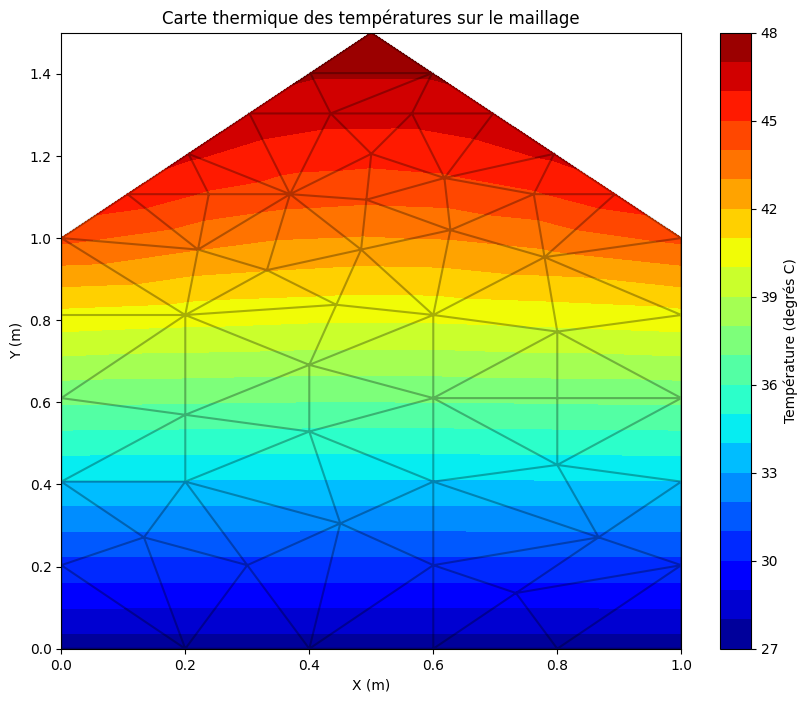

In [15]:
Uh1 = validation_pas_a_pas(FichierMaillage, 1, 25, 1.2*40, 0)

- Température max : 47.61861966878903
- Température min : 27.405391526679534
- Température moyenne : 38.70904176087704

----------------------------
### Toiture noir
Alpha = 10, tempSol = 25, tempToit = 1.3 * 40, f = 0

nbn=56
nbe=85
nba=25
refn=[2 3 2 3 3 0 3 2 2 0 0 0 0 0 2 2 0 0 0 0 0 2 2 2 0 0 0 0 2 2 0 0 0 0 1 1 0
 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 1 1]
reft=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
refa=[2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3]
K=
[[ 0.16333767  0.05140931  0.         ...  0.          0.
   0.        ]
 [ 0.05140931  0.32983904  0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.16333767 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.24865993 -0.00333333
   0.03133165]
 [ 0.          0.          0.         ... -0.00333333  0.24865993
   0.03133165]
 [ 0.          0.          0.         ...  0.03133165  0.03133165
   0.2153266 ]]
F=
[ 5.         10.          5.         10.         10.          0.
 10.          0.          0.          0.          0.          0.
  0.          0.   

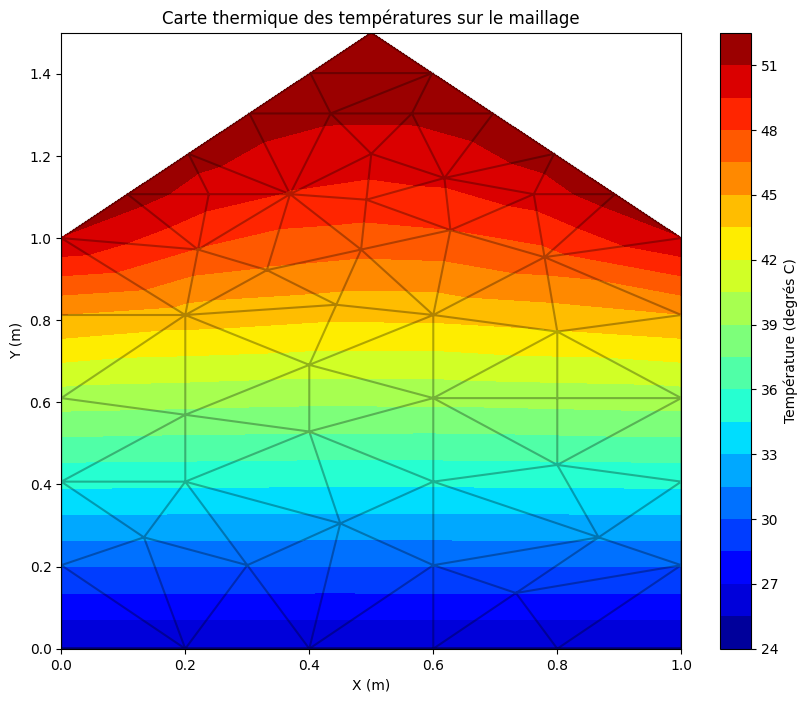

In [16]:
Uh2 = validation_pas_a_pas(FichierMaillage, 10, 25, 1.3*40, 0)

- Température max : 52.029163358606
- Température min : 25.348703676020413
- Température moyenne : 41.43358363521184

----------------------------
### Toiture vitre
Alpha = 10e6, tempSol = 25, tempToit = 1.1 * 40, f = 0.25

nbn=56
nbe=85
nba=25
refn=[2 3 2 3 3 0 3 2 2 0 0 0 0 0 2 2 0 0 0 0 0 2 2 2 0 0 0 0 2 2 0 0 0 0 1 1 0
 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 1 1]
reft=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
refa=[2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3]
K=
[[ 1.33333363e+05  6.66666514e+04  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.66666514e+04  2.66666730e+05  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.33333363e+05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.85326663e+05
  -3.33333342e-03  4.63316349e+04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.33333342e-03
   1.85326663e+05  4.63316349e+04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.63316349e+04
   4.63316349e+04  1

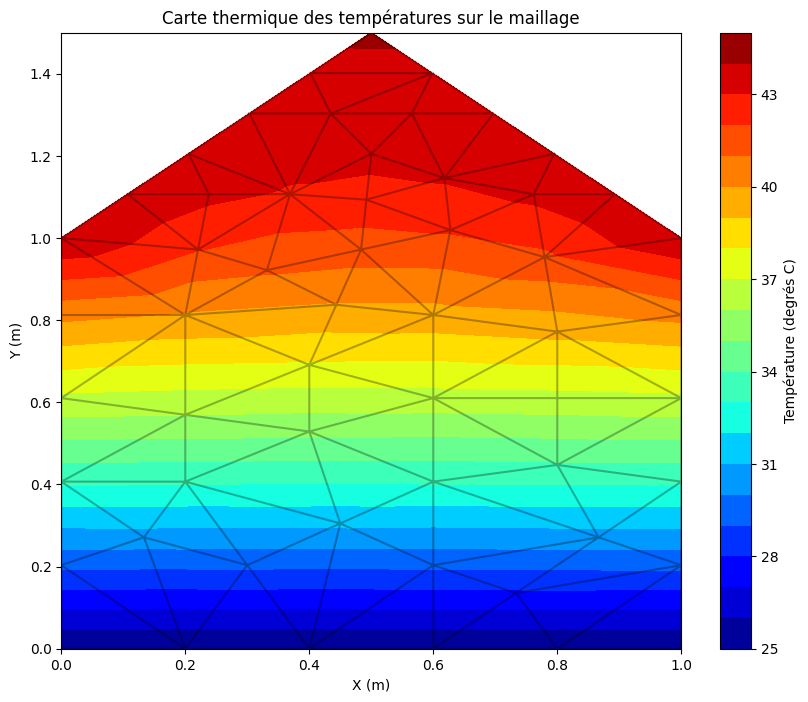

In [17]:
Uh3 = validation_pas_a_pas(FichierMaillage, 10e6, 25, 1.1*40, 0.25)

- Température max : 44.00000004406034
- Température min : 25.000000317283277
- Température moyenne : 37.27965073801681

----------------------------
## Validation croisée

In [18]:
# Résultat de FreeFem avec les mêmes paramètres alpha, uE et f pour chacune des situations
UhFF1=[25,25,25,25,25,27.7847,25,29.191,29.1892,29.1728,30.5816,29.1637,30.5846,31.2405,33.4111,33.4126,33.3619,33.3147,34.2055,35.7764,37.5665,37.7264,42.4134,37.7445,36.7202,37.4028,38.9785,40.9121,42.4104,48,41.6789,41.7211,41.2849,44.4418,48,48,43.8599,44.8131,46.6912,43.4058,44.783,46.6817,48,45.5256,48,45.9664,46.3291,48,46.6598,48,47.4949,47.505,48,48,48,48]
UhFF2=[25,25,25,25,25,28.2689,25,29.9198,29.9177,29.8985,31.5523,29.8878,31.5559,32.3258,34.8739,34.8757,34.8161,34.7608,35.8064,37.6505,39.752,39.9397,45.4418,39.961,38.7585,39.5598,41.4095,43.6795,45.4383,52,44.5796,44.6292,44.117,47.823,52,52,47.1399,48.2588,50.4635,46.6069,48.2235,50.4524,52,49.0952,52,49.6127,50.0385,52,50.4268,52,51.4071,51.4189,52,52,52,52]
UhFF3=[25,25,25,25,25,27.3004,25,28.4621,28.4606,28.4471,29.6109,28.4396,29.6134,30.1552,31.9483,31.9495,31.9076,31.8687,32.6045,33.9022,35.381,35.5131,39.385,35.5281,34.6819,35.2458,36.5475,38.1448,39.3825,44,38.7782,38.8131,38.4527,41.0606,44,44,40.5799,41.3673,42.9188,40.2048,41.3425,42.9109,44,41.9559,44,42.3201,42.6197,44,42.8929,44,43.5828,43.5911,44,44,44,44]

#### Toiture blanche

In [19]:
print(f"{np.linalg.norm(UhFF1 - Uh1)}")

11.979127678843282


#### Toiture noir

In [20]:
print(f"{np.linalg.norm(UhFF2 - Uh2)}")

2.2818387303536323


#### Toiture vitrée

In [21]:
print(f"{np.linalg.norm(UhFF3 - Uh3)}")

6.1205239248166885


On remarque une certaine concordance entre les résultats obtenus avec Freefem et ceux obtenus grâce à notre programme python.

## Conclusion
On remarque que la meilleure toiture, celle qui a la conductivité thermique la plus faible est celle vitrée, elle a les températures les plus basses, suivit de la toiture blanche puis enfin de la toiture noir. <br>
On peut donc remarquer qu'une couleur claire absorbe moins la chaleur qu'une couleur plus sombre pour ce qui est des toitures noirs ou blanches. C'est une illustration du fait qu'on porte majoritairement des couleurs claires